In [22]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import sklearn
import scipy
import PIL
import os

In [23]:
#Q2-1
mountain1 = np.array(plt.imread("./mountain1.jpg")) #374*517*3
mountain2 = np.array(plt.imread("./mountain2.jpg"))

In [24]:
len(mountain2[1])

517

H = homography(u1, v1, u2, v2)
Usage:
Computes the homography H using the Direct Linear Transformation
Arguments:
u1, v1: normalised (u,v) coordinates from image 1
u2, v2: normalised (u,v) coordinates from image 2
Output:
H: the 3×3 homography matrix that warps normalised coordinates

In [25]:
#Q2-2

def matrix_A(u1, v1, u2, v2):
    '''
    martix_A returns a matrix which is of size 2n*9 and is constructed based on the input coordinates
    '''
    leng = len(u1)
    for i in range(leng):
        temp = np.matrix([[0, 0, 0, -u1[i], -v1[i], -1, u1[i]*v2[i], v1[i]*v2[i], v2[i]],
                          [u1[i], v1[i], 1, 0, 0, 0, -u1[i]*u2[i], -v1[i]*u2[i], -u2[i]]])
        if i == 0:
            mat_a = temp
        else:
            mat_a = np.concatenate((mat_a, temp), axis=0)
    return mat_a
    

def homography(u1, v1, u2, v2):
    '''
    homography computes the homography H using the Direct Linear Transformation
    Requires: size of (u1, v1) and (u2, v2) >= 4, input points normalised, not on the same line
    '''
    #construct matrix A of size 2n*9 
    a = matrix_A(u1, v1, u2, v2) 
    u, s, vh = np.linalg.svd(a, True, True, False)
    H = np.reshape(vh[-1], (3, 3))
    return H

In [26]:
#Q2-3
def compute_normalisation_matrix(img_src, img_out, type):
    '''
    compute_normalisation_matrix takes an image and calculate its normalization matrix based on its size
    '''
    if type == "src":
        img = img_src
    elif type == "out":
        img = img_out
    
    w = len(img[0])
    h = len(img)
    #normalization matrix construction
    nm_matrix = np.array([[w+h, 0, w/2], [0, w+h, h/2], [0, 0, 1]])
    nm_matrix = np.linalg.inv(nm_matrix)  
    return nm_matrix


def homography_w_normalisation(u1, v1, u2, v2, img_src, img_out):
    '''
    homography_w_normalisation implements DLT homography with input points that are unnormalised
    Requires: size of (u1, v1) and (u2, v2) >= 4, not on the same line
    '''
    leng = len(u1)
    w1 = [1] * leng
    w2 = [1] * leng 
    #compute the normalisation matrices for points from the two images
    T = compute_normalisation_matrix(img_src, img_out, "src")
    T_prime = compute_normalisation_matrix(img_src, img_out, "out")
    for i in range(leng):
        unm_homo_pt1 = np.matrix([u1[i], v1[i], w1[i]])
        unm_homo_pt2 = np.matrix([u2[i], v2[i], w2[i]])
        #normalization
        u1[i] = np.matmul(T, np.transpose(unm_homo_pt1))[0, 0]
        v1[i] = np.matmul(T, np.transpose(unm_homo_pt1))[1, 0]
        w1[i] = np.matmul(T, np.transpose(unm_homo_pt1))[2, 0]
      
        u2[i] = np.matmul(T_prime, np.transpose(unm_homo_pt2))[0, 0]
        v2[i] = np.matmul(T_prime, np.transpose(unm_homo_pt2))[1, 0]
        w2[i] = np.matmul(T_prime, np.transpose(unm_homo_pt2))[2, 0]

    #construct matrix A of size 2n*9    
    a = matrix_A(u1, v1, u2, v2)
    u, s, vh = np.linalg.svd(a, full_matrices=True, compute_uv=True, hermitian=False)
    H_til = np.reshape(vh[-1], (3, 3))
    #denormalize H
    H = np.matmul(np.matmul(np.linalg.inv(T_prime), H_til), T)
    return H


In [27]:
a = compute_normalisation_matrix(mountain1, mountain2, "out")
np.linalg.inv(a)

array([[891. ,   0. , 258.5],
       [  0. , 891. , 187. ],
       [  0. ,   0. ,   1. ]])

In [28]:
#Q2-4
def sift(img1, img2):
    '''
    sift takes two images as input and outputs an array of matching points of the two images
    '''
    #turn the two images into grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) 
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) 

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)
    #matching
    match = cv2.BFMatcher().match(des1, des2)
    #sampling w/ seed 42
    np.random.seed(42)
    match_smapling = np.random.choice(match, size=int(np.ceil((len(match)/2))))

    #convert the coordinates into numpy arrays 
    leng_sample = len(match_smapling)
    lst1 = []
    lst2 = []
    for i in range(leng_sample):
        lst1 += [kp1[match_smapling[i].queryIdx].pt]
        lst2 += [kp2[match_smapling[i].trainIdx].pt]

    #save the two lists of correspondences to local
    np.save("match_sample_img1.npy", lst1)
    np.save("match_sample_img2.npy", lst2)
    #output an image with conrrespondences connected
    output_image = cv2.drawMatches(img1, kp1, img2, kp2, match_smapling, None, flags = 2)
    plt.imshow(output_image)

    return match_smapling, lst1, lst2

(array([< cv2.DMatch 0x13b8aceb0>, < cv2.DMatch 0x13b8ae5b0>,
        < cv2.DMatch 0x13b81f1d0>, < cv2.DMatch 0x13b8a9d30>,
        < cv2.DMatch 0x13b8a8c30>, < cv2.DMatch 0x13b81ed90>,
        < cv2.DMatch 0x13b8ad010>, < cv2.DMatch 0x13b81f2f0>,
        < cv2.DMatch 0x13b8ac350>, < cv2.DMatch 0x13b8a8dd0>,
        < cv2.DMatch 0x13b8ac7d0>, < cv2.DMatch 0x13b8a9310>,
        < cv2.DMatch 0x13b8ada90>, < cv2.DMatch 0x13b8a8570>,
        < cv2.DMatch 0x13b8a9c50>, < cv2.DMatch 0x13b81de10>,
        < cv2.DMatch 0x13b8a8270>, < cv2.DMatch 0x13b8ac090>,
        < cv2.DMatch 0x13b8ace30>, < cv2.DMatch 0x13b8a9e30>,
        < cv2.DMatch 0x13b8aa2b0>, < cv2.DMatch 0x13b8aba50>,
        < cv2.DMatch 0x13b8add10>, < cv2.DMatch 0x13b81fa50>,
        < cv2.DMatch 0x13b8adad0>, < cv2.DMatch 0x13b8ab8b0>,
        < cv2.DMatch 0x13b8adad0>, < cv2.DMatch 0x13b8aa930>,
        < cv2.DMatch 0x13b8acb10>, < cv2.DMatch 0x13b8ab3b0>,
        < cv2.DMatch 0x13b81d850>, < cv2.DMatch 0x13b8acc30>,
        

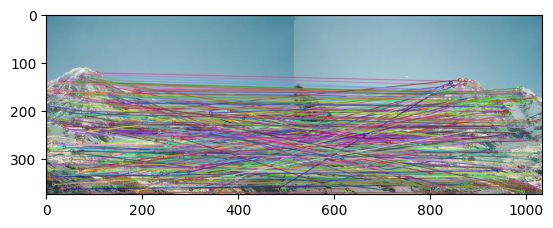

In [29]:
sift(mountain1, mountain2)

In [57]:
#Q2-5
def homography_w_normalisation_ransac(sample_img1, sample_img2, dist_thr, inlier_thr, iteration, img_src, img_out):
    '''
    homography_w_normalisation_ransac estimates a homography matrix based on the correspondences from two images 
    using the RANSAC algorithm
    '''
    assert len(sample_img1) == len(sample_img2)
    dist = 0
    best_fit = 0
    count = 0
    min_dist = 0
    discrepency = 0
    inlier_num = 0
    #randomly choose 4 points wo/ replacement and construct H for "iteration" times
    for i in range(iteration):
        index_lst = np.random.choice(np.arange(0, len(sample_img1)), 4, False)
        #construct u1, u2, v1, v2
        u1 = [sample_img1[index_lst[0]][0], sample_img1[index_lst[1]][0], sample_img1[index_lst[2]][0], sample_img1[index_lst[3]][0]]
        u2 = [sample_img2[index_lst[0]][0], sample_img2[index_lst[1]][0], sample_img2[index_lst[2]][0], sample_img2[index_lst[3]][0]]
    
        v1 = [sample_img1[index_lst[0]][1], sample_img1[index_lst[1]][1], sample_img1[index_lst[2]][1], sample_img1[index_lst[3]][1]]
        v2 = [sample_img2[index_lst[0]][1], sample_img2[index_lst[1]][1], sample_img2[index_lst[2]][1], sample_img2[index_lst[3]][1]]
        #call the homography_w_normalisation as points are not normalised
        H = homography_w_normalisation(u1, v1, u2, v2, img_src, img_out)
        #calculate distance
        for j in range(len(sample_img1)):
            source_pt = [[sample_img1[j][0]], [sample_img1[j][1]], [1]]
            approx_pt = np.matmul(H, np.array(source_pt))
            if approx_pt[2] == 0:  #avoid dividing by 0
                continue  
            approx_pt[0] /= approx_pt[2] #homo -> inhomo
            approx_pt[1] /= approx_pt[2]
            approx_pt[2] /= approx_pt[2]
            actual_pt = [[sample_img2[j][0]], [sample_img2[j][1]], [1]]
            #calculate the Euclidean distance between points after transformation (approx_pt) and actual corresponding points
            dist_temp = np.sqrt((actual_pt[0] - approx_pt[0])**2 + (actual_pt[1] - approx_pt[1])**2 + (actual_pt[2] - approx_pt[2])**2)
            if dist_temp < dist_thr: #the approx_pt is an inlier!
                count += 1
                discrepency += dist_temp
            dist += dist_temp #calculate the total distance for all corresponding points
        if i == 0:
            min_discrepency = discrepency

        elif count > inlier_thr: #the returning H transforms at least "inlier_thr" points into inliers
            if discrepency < min_discrepency:
                min_dist = discrepency   
                best_fit = H
                inlier_num = count     
        discrepency = 0
        count = 0
        dist = 0
    
    # if there isn't a transformation which makes at least inlier_thr points become inliers, we recursively run
    # the function by doubling its iteration
    if inlier_num < inlier_thr:
        return homography_w_normalisation_ransac(sample_img1, sample_img2, dist_thr, inlier_thr, iteration*2, img_src, img_out)
    return best_fit 


#ref: https://en.wikipedia.org/wiki/Random_sample_consensus

In [58]:
sample_img1 = np.load("match_sample_img1.npy")
sample_img2 = np.load("match_sample_img2.npy")
homography_w_normalisation_ransac(sample_img1, sample_img2, 50, 100, 100, mountain1, mountain2)

matrix([[ 4.17449971e-01,  1.15660037e-01,  1.53632797e+02],
        [-1.55446373e-01,  5.66920110e-01,  2.65439960e+01],
        [-3.64989902e-04,  2.06899956e-05,  6.07148776e-01]])

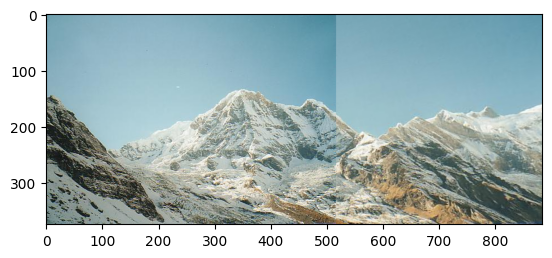

In [60]:
#Q2-6
#result from prev questions
H = np.matrix([[ 4.17449971e-01,  1.15660037e-01,  1.53632797e+02],
        [-1.55446373e-01,  5.66920110e-01,  2.65439960e+01],
        [-3.64989902e-04,  2.06899956e-05,  6.07148776e-01]])
moutain1 = plt.imread("./mountain1.jpg")
moutain2 = plt.imread("./mountain2.jpg")

#warp mountain1 by the homography matrix H and stitch it with mountain2                    
img = cv2.warpPerspective(mountain1, H, (2*len(mountain2[1]) - 150, len(mountain2))) #switch the order of row and col as we start with column first
img[0:len(mountain2), 0:len(mountain2[0])] = mountain2 #make mountain2 be the left side of the image as it is the one being stitched

output_image = cv2.addWeighted(img, 0, img, 1, 0)
plt.imshow(output_image)

